# Adversarial attacks
Нейронные сети показывают хороший результат во многих задачах машинного обучения, в частности в задаче классификации. Однако не так давно, исследовали обнаружили, что нейронные сети сильно неусточивы к состязательным атакам.

Состязательные атаки - это особый вид искажений данных, которые несущественны для восприятия человека, но приводящие к неправильному ответу нейронных сетей.

Изучение данного вопроса является очень важным, так как с развитием технологий искусственного интеллекта, в частности беспилотного транспорта, машинное обучение будет затрагивать все больше областей нашей жизнедеятельности. От безопасности и устойчивости к различного рода помехам, а также целенаправленным атакам, будет зависеть наша безопасность, а в некоторых случаях от принятие правильного решения системы искусственного интеллекта будет зависеть жизнь человека.

In [ ]:
import torch
import numpy as np
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

import os
from matplotlib import colors, pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [ ]:
!gdown --id 1lnifrk9taIMs2zxvACemTnHTCk64saLZ

Downloading...
From: https://drive.google.com/uc?id=1lnifrk9taIMs2zxvACemTnHTCk64saLZ
To: /content/journey-springfield.zip
546MB [00:09, 55.9MB/s]


In [ ]:
!git clone https://github.com/semyon829/optimization_project

Cloning into 'optimization_project'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 32 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

CUDA is available. Training on GPU


В качестве датасета для исследования состязательных атак будет использовать датасет с [соревнования]((https://www.kaggle.com/c/journey-springfield)) на платформе kaggle.

In [ ]:
!unzip -q journey-springfield.zip -d dataset

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode, model=None, attack_mode = None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        if model:
            self.model = model
        self.attack_mode = attack_mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        label = self.labels[index]
        label = self.label_encoder.transform([label])
        label = label.item()
        if self.mode == 'train':
            if self.attack_mode:
                transform = transforms.Compose([
                    transforms.ToTensor(),
                    self.attack_mode(self.model, label),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.RandomPerspective(),
                    transforms.Normalize([0, 0, 0], [1, 1, 1]) 
                ])
            else:
                transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.RandomPerspective(),
                    transforms.Normalize([0, 0, 0], [1, 1, 1]) 
                ])
        else:
            if self.attack_mode:
                transform = transforms.Compose([
                    transforms.ToTensor(),
                    self.attack_mode(self.model, label),
                    transforms.Normalize([0, 0, 0], [1, 1, 1]) 
                ])
            else:
                transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0, 0, 0], [1, 1, 1]) 
                ])
             
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            return x, label
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

[Fast gradient sign method](https://arxiv.org/pdf/1412.6572.pdf)

https://arxiv.org/pdf/1412.6572.pdf

В отличие от предыдущих работ, в которых эффект состязательных атак объяснялся чрезмерной нелинейностью нейронных сетей и переобучением, авторы данной статьи утверждают, что в нейронных сетях достаточно локально-линейного поведения, за счет этого можно построить линейные состязательные атаки. 

Во многих задачах значения входных данных, на которое будет реагировать классификатор, ограничено. Например, цифровые изображения часто используют только 8 бит на пиксель, поэтому они отбрасывают всю информацию ниже 1/255 динамического диапазона. Поскольку точность признаков ограничена, для классификатора нерационально реагировать на ввод x иначе, чем на состязательный ввод x˜ = x + η

Если рассмотреть результат произведения вектора весов на состязательный ввод:

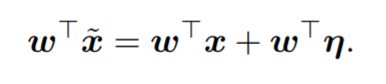

Мы можем максимизировать увеличение активизации с учетом ограничения максимальной нормы на η, присвоив η = sign (w). Если w имеет n измерений и средняя величина элемента вектора весов равна m, то активация вырастет на mn. Поскольку η не растет с ростом n, а активация растет линейно, но изменение активации, вызванное возмущением η, может расти линейно с увеличением n, то для задач большой размерности мы можем внести множество бесконечно малых изменений во входные данные, которые в сумме до одного большого изменения на выходе.

Как утверждают авторы мы можем обобщить данное утверждение на нейронные сети, так как такие функции активации, как RELU, LeakyRELU и т.д. имеют локальные линейности, к тому же нейронные сети это представляют собой простнранство большой размерности. Авторы предлагают использовать следующее возмущения для генерации состязательных атак:

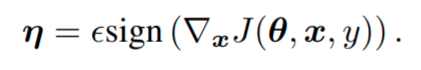

θ - это параметры модели, x - вход в модель, y - целевые метки, связанные с x, а J (θ, x, y) - функция потерь, используемая для обучения нейронной сети.

[ITERATIVE LEAST-LIKELY CLASS METHOD](https://arxiv.org/pdf/1607.02533.pdf)

https://arxiv.org/pdf/1607.02533.pdf

Вышеуказанный метод просто пытаются увеличить стоимость правильного класса, не указывая, какой из неправильных классов модель должна выбрать. Таких методов достаточно для применения к наборам данных, где количество классов невелико и все классы сильно отличаются друг от друга. В датасетах, с гораздо большим количеством классов и различной степенью значимости различий между классами, этот метод может привести к неинтересным ошибочным классификациям, таким как принятие одной породы ездовых собак за другую породу ездовых собак. Чтобы создавать более интересные ошибки, аторы статьи вводят итерационный метод наименее вероятного класса. Этот итеративный метод пытается создать состязательное изображение, которое будет классифицировано как определенный желаемый целевой класс. 
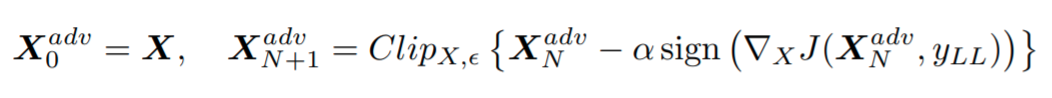

X - входное изображение,yLL - мета изображения, которую мы хотим получить при целенаправленной атаке



In [ ]:
class RandomFGSM(torch.nn.Module):
    def __init__(self, model, label, p=0.5, eps=0.07):
        super().__init__()
        self.p = p
        self.eps = eps
        self.model = model
        self.label = label
    def forward(self, img):
        if torch.rand(1) < self.p:
            self.model.eval()
            loss = nn.CrossEntropyLoss()
            img = img.to(DEVICE)
            self.label = torch.tensor([self.label], dtype=torch.long)
            self.label = self.label.to(DEVICE)
            img.requires_grad = True
            output = self.model(img.unsqueeze(dim=0))
            cost = loss(output, self.label).to(DEVICE)
            grad = torch.autograd.grad(
                cost, img, retain_graph=False, create_graph=False)[0]
            adv_image = img + self.eps*grad.sign().detach()
            return adv_image.cpu()
        return img        

In [ ]:
class RandomILLCM(torch.nn.Module):
    def __init__(self, model, label, n_iter=5, false_label=5, p=0.5, eps=0.007):
        super().__init__()
        self.p = p
        self.eps = eps
        self.model = model
        self.false_label = false_label
        self.n_iter = n_iter
    def forward(self, img):
        if torch.rand(1) < self.p:
            self.model.eval()
            loss = nn.CrossEntropyLoss()
            img = img.to(DEVICE)
            self.false_label = torch.tensor([self.false_label], dtype=torch.long)
            self.false_label = self.false_label.to(DEVICE)
            img.requires_grad = True
            output = self.model(img.unsqueeze(dim=0))
            adv_im = img
            for i in range(self.n_iter):
                cost = loss(output, self.false_label).to(DEVICE)
                grad = torch.autograd.grad(cost, adv_im,
                                        retain_graph=False, create_graph=False)[0]
                adv_im = adv_im - self.eps*grad.sign().detach()
                output = self.model(adv_im.unsqueeze(dim=0))
            return adv_im.cpu()
        return img   

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0, 0, 0])
    std = np.array([1, 1, 1])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('dataset/train/simpsons_dataset')
TEST_DIR = Path('dataset/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделим на тренировочный и валидационный датасет в отношении 3 к 1

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, 
                                          test_size=0.25, 
                                          stratify=train_val_labels)

Посмотрим на количесто классов в датасете

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
len(set(train_val_labels))

42

Посмотрим на экземпляры из валидационного датасета

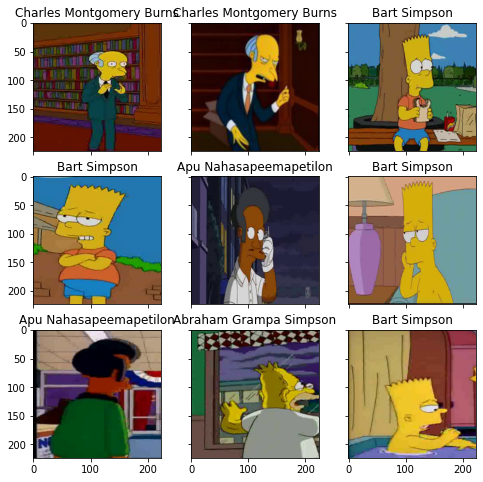

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

Напишем собственную нейросеть для классификации изображений. На ней же и будем проверять применение состязательных атак

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2_1 = nn.Sequential(
            nn.BatchNorm2d(8),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.drop1 = nn.Dropout(p=0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3_1 = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4_1 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv4_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.drop2 = nn.Dropout(p=0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.conv5_1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96)
        )
        self.conv5_2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.drop3 = nn.Dropout(p=0.5)
        self.pool5 = nn.MaxPool2d(kernel_size=2)
        
        self.out = nn.Sequential(
            nn.BatchNorm1d(96 * 7 * 7), 
            nn.Linear(96 * 7 * 7, n_classes)
        )
  
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x) + x
        x = self.pool1(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x) + x
        x = self.drop1(x)
        x = self.pool2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x) + x
        x = self.pool3(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x) + x
        x = self.drop2(x)
        x = self.pool4(x)
        x = self.conv5_1(x)
        x = self.conv5_2(x) + x
        x = self.drop3(x)
        x = self.pool5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, number_model):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        max_val_acc = 0
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)    
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            if val_acc > max_val_acc:
                max_val_acc = val_acc
                torch.save(model.state_dict(),
                           f'/content/gdrive/My Drive/models{number_model}/epoch{epoch}.pth')

            if len(history) > 10 and val_acc < history[-10][3]:
                break
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Обучим нашу нейросеть классифицировать изображения из датасета

Запускать не нужно, иначе будет очень долго считаться, ниже обученная нейросеть подгружается из папки

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=100, batch_size=128, number_model='')

# Оценки сети

In [ ]:
def predict_on_category(model, dataset):
    acc_ls = {i:0 for i in range(len(set(train_val_labels)))}
    len_ls = {i:0 for i in range(len(set(train_val_labels)))}
    for i, inputs in enumerate(dataset):
        pearson = inputs[0].to(DEVICE).unsqueeze(dim=0)
        model.eval()
        label = inputs[1]
        logits = model(pearson).cpu().detach()
        probs = nn.functional.softmax(logits).numpy()[0]
        pred_class = np.argmax(probs)
        acc = int(pred_class == label)
        acc_ls[label] += acc
        len_ls[label] += 1
    acc_ls = {i:acc_ls[i] / len_ls[i] for i in acc_ls}
    class_ls = [val_dataset.label_encoder.inverse_transform([i])[0] for i in acc_ls]
    df = np.concatenate((np.expand_dims(class_ls, axis=1),
                         np.expand_dims(list(acc_ls.values()), axis=1), 
                         np.expand_dims(list(len_ls.values()), axis=1)), axis=1)
    df = pd.DataFrame(df, columns=['class', 'accuracy', 'number'], index=list(acc_ls.keys()))
    return acc_ls, len_ls, df

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
path_to_model = 'optimization_project/models'
model = os.listdir(path_to_model)[-1]
simple_cnn.load_state_dict(torch.load(os.path.join(path_to_model, model)))
model

'epoch45.pth'

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc_category, len_category, df = predict_on_category(simple_cnn, val_dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


<BarContainer object of 42 artists>

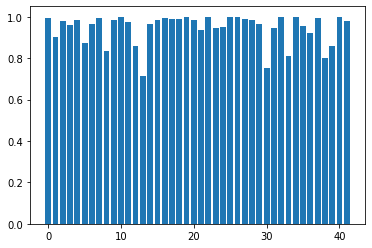

In [ ]:
plt.figure()
plt.bar(list(acc_category.keys()), list(acc_category.values()))

In [ ]:
df

,class,accuracy,number
0,abraham_grampa_simpson,0.9956140350877193,228
1,agnes_skinner,0.9,10
2,apu_nahasapeemapetilon,0.9807692307692307,156
3,barney_gumble,0.9615384615384616,26
4,bart_simpson,0.9851190476190477,336
5,carl_carlson,0.875,24
6,charles_montgomery_burns,0.9664429530201343,298
7,chief_wiggum,0.9959514170040485,247
8,cletus_spuckler,0.8333333333333334,12
9,comic_book_guy,0.9829059829059829,117


In [ ]:
acc_ls = np.array(list(acc_category.values()))
len_ls = np.array(list(len_category.values()))
acc = np.sum(acc_ls * len_ls) / np.sum(len_ls)
acc

0.9826136797860145

# Оценка точности при использовании FGSM атаки

In [ ]:
def fgsm_accuracy(model, model1, val_dataset, eps=0.07):
    model.eval()
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    running_corrects = 0
    processed_data = 0
    loss = nn.CrossEntropyLoss()
    adv_images = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        inputs.requires_grad = True
        outputs = model(inputs)
        cost = loss(outputs, labels).to(DEVICE)
        grad = torch.autograd.grad(cost, inputs,
                                   retain_graph=False, create_graph=False)[0]
        adv_im = inputs + eps*grad.sign().detach()
        adv_images.append(adv_im.detach().cpu())
        out = model1(adv_im)
        preds = torch.argmax(out, 1)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    val_acc = running_corrects.double() / processed_data
    return val_acc, torch.cat(adv_images, dim=0)

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc, adv_images = fgsm_accuracy(simple_cnn, simple_cnn, val_dataset)

При использовании FGSM атаки нейросеть стала неправильно классифицировать изображения в большинстве случаев

In [ ]:
acc

tensor(0.1989, device='cuda:0', dtype=torch.float64)

Посмотрим на примеры неправильной классификации. Слева расположены входные изображения, по центру искаженные изображения с неправильно классифицированной меткой и справа экземпляры неправильных классов

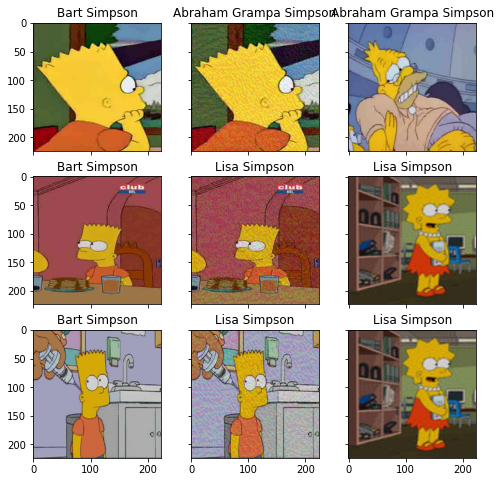

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8),
                       sharey=True, sharex=True)
for i in range(3):
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    adv_im = adv_images[random_characters]
    adv_pred = simple_cnn(adv_im.unsqueeze(dim=0).to(DEVICE))
    adv_label = torch.argmax(adv_pred, 1)
    adv_label = val_dataset.label_encoder.inverse_transform([adv_label.cpu()])[0]
    adv_label1 = " ".join(map(lambda x: x.capitalize(),
                                adv_label.split('_')))
    img_label = val_dataset.label_encoder.inverse_transform([label])[0]
    img_label = " ".join(map(lambda x: x.capitalize(),
                                img_label.split('_')))
    image_adv_category = SimpsonsDataset(
        [Path(f'dataset/train/simpsons_dataset/{adv_label}/pic_0000.jpg')], mode='val')[0][0]
    imshow(im_val.data.cpu(), title=img_label, plt_ax=ax[i][0])
    imshow(adv_im.data.cpu(), title=adv_label1, plt_ax=ax[i][1])
    imshow(image_adv_category, title=adv_label1, plt_ax=ax[i][2])

# Применение FGSM атаки прямо во время обучения сети

Попробуем теперь обучить нейросеть применяя FGSM атаки во время обучения, таким образом аугментируя наши данные и заставляя нашу нейросеть обучаться сопротивляться внешним атакам. Это можно рассматривать как своего рода регуляризацию

In [ ]:
path_to_model = 'optimization_project/models'
model = os.listdir(path_to_model)[-1]
simple_cnn.load_state_dict(torch.load(os.path.join(path_to_model, model)))

<All keys matched successfully>

In [ ]:
val_dataset = SimpsonsDataset( 
    val_files, mode='val', model=simple_cnn, attack_mode=RandomFGSM)
train_dataset = SimpsonsDataset(
    train_files, mode='train', model=simple_cnn, attack_mode=RandomFGSM)

Запускать не нужно, иначе будет очень долго обучаться, ниже представлена загрузка уже обученной модели

In [ ]:
history = train(train_dataset, val_dataset, 
                model=simple_cnn, epochs=100, 
                batch_size=128, number_model='_with_FGSM')

epoch:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


loss 1.264443723025827


epoch:   1%|          | 1/100 [05:34<9:11:28, 334.23s/it]


Epoch 001 train_loss: 1.2644     val_loss 1.0740 train_acc 0.6879 val_acc 0.7216
loss 0.7322383755801992


epoch:   2%|▏         | 2/100 [10:58<9:01:12, 331.36s/it]


Epoch 002 train_loss: 0.7322     val_loss 0.6732 train_acc 0.7964 val_acc 0.8175
loss 0.5779133384657086


epoch:   3%|▎         | 3/100 [16:23<8:52:28, 329.36s/it]


Epoch 003 train_loss: 0.5779     val_loss 0.5383 train_acc 0.8357 val_acc 0.8571
loss 0.4811282946741636


epoch:   4%|▍         | 4/100 [21:54<8:47:51, 329.91s/it]


Epoch 004 train_loss: 0.4811     val_loss 0.6353 train_acc 0.8631 val_acc 0.8376
loss 0.44988267627428485


epoch:   5%|▌         | 5/100 [27:25<8:42:57, 330.29s/it]


Epoch 005 train_loss: 0.4499     val_loss 0.5314 train_acc 0.8724 val_acc 0.8569
loss 0.42920239537496824


epoch:   6%|▌         | 6/100 [33:00<8:39:21, 331.50s/it]


Epoch 006 train_loss: 0.4292     val_loss 0.4454 train_acc 0.8755 val_acc 0.8900
loss 0.39238905468726054


epoch:   7%|▋         | 7/100 [38:29<8:32:51, 330.87s/it]


Epoch 007 train_loss: 0.3924     val_loss 0.5840 train_acc 0.8866 val_acc 0.8515
loss 0.39183012379818766


epoch:   8%|▊         | 8/100 [43:55<8:24:56, 329.31s/it]


Epoch 008 train_loss: 0.3918     val_loss 0.4441 train_acc 0.8871 val_acc 0.8905
loss 0.3692945031969705


epoch:   9%|▉         | 9/100 [49:22<8:18:20, 328.58s/it]


Epoch 009 train_loss: 0.3693     val_loss 0.5490 train_acc 0.8927 val_acc 0.8657
loss 0.34656931795438495


epoch:  10%|█         | 10/100 [54:45<8:10:40, 327.12s/it]


Epoch 010 train_loss: 0.3466     val_loss 0.4800 train_acc 0.8976 val_acc 0.8901
loss 0.3309075893057449


epoch:  11%|█         | 11/100 [1:00:07<8:02:50, 325.51s/it]


Epoch 011 train_loss: 0.3309     val_loss 0.4807 train_acc 0.9049 val_acc 0.8838
loss 0.33943089895760514


epoch:  12%|█▏        | 12/100 [1:05:29<7:55:47, 324.40s/it]


Epoch 012 train_loss: 0.3394     val_loss 0.4732 train_acc 0.8990 val_acc 0.8905
loss 0.3207683476458477


epoch:  13%|█▎        | 13/100 [1:10:54<7:50:34, 324.53s/it]


Epoch 013 train_loss: 0.3208     val_loss 0.4813 train_acc 0.9057 val_acc 0.8901
loss 0.30961898636708585


epoch:  14%|█▍        | 14/100 [1:16:20<7:45:50, 325.01s/it]


Epoch 014 train_loss: 0.3096     val_loss 0.4694 train_acc 0.9090 val_acc 0.8859
loss 0.22328638944935514


epoch:  15%|█▌        | 15/100 [1:21:43<7:39:41, 324.48s/it]


Epoch 015 train_loss: 0.2233     val_loss 0.4035 train_acc 0.9334 val_acc 0.9073
loss 0.19456464998531786


epoch:  16%|█▌        | 16/100 [1:27:03<7:32:25, 323.16s/it]


Epoch 016 train_loss: 0.1946     val_loss 0.3784 train_acc 0.9429 val_acc 0.9106
loss 0.17280445809043193


epoch:  17%|█▋        | 17/100 [1:32:21<7:24:53, 321.61s/it]


Epoch 017 train_loss: 0.1728     val_loss 0.4050 train_acc 0.9489 val_acc 0.9119
loss 0.17562788168110888


epoch:  18%|█▊        | 18/100 [1:37:41<7:18:55, 321.17s/it]


Epoch 018 train_loss: 0.1756     val_loss 0.4600 train_acc 0.9485 val_acc 0.9056
loss 0.1808721349454851


epoch:  19%|█▉        | 19/100 [1:42:59<7:12:10, 320.13s/it]


Epoch 019 train_loss: 0.1809     val_loss 0.3930 train_acc 0.9460 val_acc 0.9157
loss 0.16870024655645718


epoch:  20%|██        | 20/100 [1:48:19<7:06:52, 320.16s/it]


Epoch 020 train_loss: 0.1687     val_loss 0.4208 train_acc 0.9511 val_acc 0.9131
loss 0.16283430616311476


epoch:  21%|██        | 21/100 [1:53:43<7:02:56, 321.22s/it]


Epoch 021 train_loss: 0.1628     val_loss 0.4028 train_acc 0.9503 val_acc 0.9119
loss 0.15088652020993146


epoch:  22%|██▏       | 22/100 [1:59:09<6:59:17, 322.53s/it]


Epoch 022 train_loss: 0.1509     val_loss 0.3858 train_acc 0.9557 val_acc 0.9209
loss 0.1592298225522292


epoch:  23%|██▎       | 23/100 [2:04:29<6:53:04, 321.87s/it]


Epoch 023 train_loss: 0.1592     val_loss 0.5013 train_acc 0.9501 val_acc 0.8980
loss 0.16062571594510702


epoch:  24%|██▍       | 24/100 [2:09:47<6:46:24, 320.85s/it]


Epoch 024 train_loss: 0.1606     val_loss 0.4468 train_acc 0.9515 val_acc 0.9058
loss 0.16143588666604866


epoch:  24%|██▍       | 24/100 [2:15:05<7:07:48, 337.74s/it]


In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
path_to_model = 'optimization_project/models_with_FGSM'
model = os.listdir(path_to_model)[-1]
simple_cnn.load_state_dict(torch.load(os.path.join(path_to_model, model)))

<All keys matched successfully>

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc, adv_images = fgsm_accuracy(simple_cnn, simple_cnn, val_dataset)

Как мы видиим нейросеть стала гораздо устойчивее к FGSM атакам

In [ ]:
acc

tensor(0.9515, device='cuda:0', dtype=torch.float64)

Рассмотрим теперь устойчивость к FGSM атакам, с другим параметром eps, на котором нейросеть не обучалась. Как мы видим к такми нейросеть также довольно неплохо способна противостоять таким атакам

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc, adv_images = fgsm_accuracy(simple_cnn, simple_cnn, val_dataset, eps=0.007)
acc

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc, adv_images = fgsm_accuracy(simple_cnn, simple_cnn, val_dataset, eps=0.03)
acc

tensor(0.9492, device='cuda:0', dtype=torch.float64)

Рассмотрим теперь точность нейросети, обученной таким способом, на обычных данных

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc_category, len_category, df = predict_on_category(simple_cnn, val_dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


<BarContainer object of 42 artists>

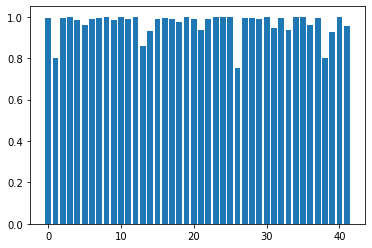

In [ ]:
plt.figure()
plt.bar(list(acc_category.keys()), list(acc_category.values()))

In [ ]:
acc_ls = np.array(list(acc_category.values()))
len_ls = np.array(list(len_category.values()))
acc = np.sum(acc_ls * len_ls) / np.sum(len_ls)
acc

0.988536492166603

Несложно заметить, что качество предсказания возросло даже на тех классах, на которых обычная наша нейросеть давала пролие значения. Таким образом обучение с использованием FGSM атак довольно хорошо показало себя на несбалансированном датасете. При этом FGSM атаки можно рассматривать как некий способ аугментации данных, а также регуляризации. При таком подходе нейросеть становится более устойчивой к таким видам атак

# Оценка ILLCM

Оценим теперь ILLCM атаку на уже защищенной сетке, котора обучалась с использование FGSM атак

In [ ]:
def illcm_accuracy(model, val_dataset, n_iter, false_label):
    model.eval()
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    running_corrects = 0
    processed_data = 0
    loss = nn.CrossEntropyLoss()
    adv_images = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        false_labels = torch.full_like(labels, false_label).to(DEVICE)
        inputs.requires_grad = True
        outputs = model(inputs)
        adv_im = inputs
        for i in range(n_iter):
            cost = loss(outputs, false_labels).to(DEVICE)
            grad = torch.autograd.grad(cost, adv_im,
                                    retain_graph=False, create_graph=False)[0]
            adv_im = adv_im - 0.007*grad.sign().detach()
            outputs = model(adv_im)
        adv_images.append(adv_im.detach().cpu())
        out = model(adv_im)
        preds = torch.argmax(out, 1)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    val_acc = running_corrects.double() / processed_data
    return val_acc, torch.cat(adv_images, dim=0)

In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
path_to_model = 'optimization_project/models_with_FGSM'
model = os.listdir(path_to_model)[-1]
simple_cnn.load_state_dict(torch.load(os.path.join(path_to_model, model)))
val_dataset = SimpsonsDataset(val_files, mode='val')

В качестве целевой метки для нашей атаки возьмем carl carlson

In [ ]:
df[df['class'] == 'carl_carlson']

,class,accuracy,number
5,carl_carlson,1.0,24


Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc, adv_images = illcm_accuracy(simple_cnn, val_dataset, 5, 5)
acc

tensor(0.0743, device='cuda:0', dtype=torch.float64)

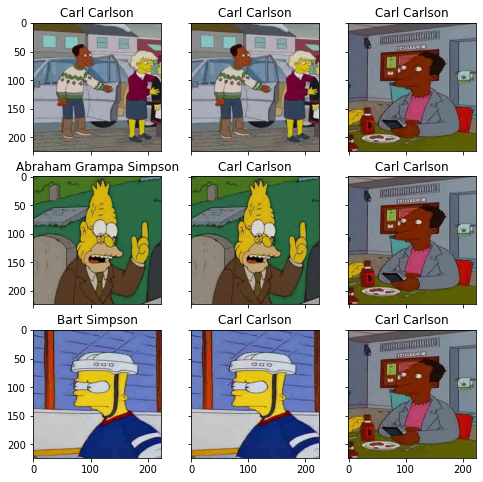

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8),
                       sharey=True, sharex=True)
for i in range(3):
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    adv_im = adv_images[random_characters]
    adv_pred = simple_cnn(adv_im.unsqueeze(dim=0).to(DEVICE))
    adv_label = torch.argmax(adv_pred, 1)
    adv_label = val_dataset.label_encoder.inverse_transform([adv_label.cpu()])[0]
    adv_label1 = " ".join(map(lambda x: x.capitalize(),
                                adv_label.split('_')))
    img_label = val_dataset.label_encoder.inverse_transform([label])[0]
    img_label = " ".join(map(lambda x: x.capitalize(),
                                img_label.split('_')))
    image_adv_category = SimpsonsDataset(
        [Path(f'dataset/train/simpsons_dataset/{adv_label}/pic_0000.jpg')], mode='val')[0][0]
    imshow(im_val.data.cpu(), title=img_label, plt_ax=ax[i][0])
    imshow(adv_im.data.cpu(), title=adv_label1, plt_ax=ax[i][1])
    imshow(image_adv_category, title=adv_label1, plt_ax=ax[i][2])

Как мы видим, точность классификации очень сильно упала даже на уже защищенной сетке. При этом многие изображения самых разных классов классифицируются нейросетью как carl carlson, метка которого была использована во время атаки

# Применение ILCCM атаки прямо во время обучения сети

Попробуем теперь защититься от данной атаки на заранее заданном классе carl carlson, пытаясь использовать данный вид атаки во время обучения сети

In [ ]:
path_to_model = 'optimization_project/models'
model = os.listdir(path_to_model)[-1]
simple_cnn.load_state_dict(torch.load(os.path.join(path_to_model, model)))

<All keys matched successfully>

In [ ]:
val_dataset = SimpsonsDataset( 
    val_files, mode='val', model=simple_cnn, attack_mode=RandomILLCM)
train_dataset = SimpsonsDataset(
    train_files, mode='train', model=simple_cnn, attack_mode=RandomILLCM)

Запускать не нужно, иначе будет очень долго обучаться, ниже представлена загрузка уже обученной модели

In [ ]:
history = train(train_dataset, val_dataset, 
                model=simple_cnn, epochs=100, 
                batch_size=128, number_model='_with_ILLCM')

epoch:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


loss 0.6728950041488095


epoch:   1%|          | 1/100 [10:08<16:43:24, 608.13s/it]


Epoch 001 train_loss: 0.6729     val_loss 1.2797 train_acc 0.8421 val_acc 0.7161
loss 0.4968858987056903


epoch:   2%|▏         | 2/100 [20:06<16:28:15, 605.05s/it]


Epoch 002 train_loss: 0.4969     val_loss 0.9718 train_acc 0.8695 val_acc 0.7514
loss 0.4460409800750722


epoch:   3%|▎         | 3/100 [30:02<16:13:51, 602.39s/it]


Epoch 003 train_loss: 0.4460     val_loss 0.9563 train_acc 0.8795 val_acc 0.7660
loss 0.39006106484368375


epoch:   4%|▍         | 4/100 [39:59<16:01:17, 600.81s/it]


Epoch 004 train_loss: 0.3901     val_loss 0.8920 train_acc 0.8915 val_acc 0.7682
loss 0.3947926168552181


epoch:   5%|▌         | 5/100 [49:53<15:48:13, 598.88s/it]


Epoch 005 train_loss: 0.3948     val_loss 0.8452 train_acc 0.8882 val_acc 0.7648
loss 0.40373389770957463


epoch:   6%|▌         | 6/100 [59:59<15:41:31, 600.98s/it]


Epoch 006 train_loss: 0.4037     val_loss 0.7238 train_acc 0.8876 val_acc 0.7875
loss 0.3580749891895315


epoch:   7%|▋         | 7/100 [1:10:03<15:32:39, 601.72s/it]


Epoch 007 train_loss: 0.3581     val_loss 0.7612 train_acc 0.9001 val_acc 0.8066
loss 0.35393107705294263


epoch:   8%|▊         | 8/100 [1:20:06<15:23:13, 602.11s/it]


Epoch 008 train_loss: 0.3539     val_loss 0.7320 train_acc 0.9009 val_acc 0.7864
loss 0.3412171735627779


epoch:   9%|▉         | 9/100 [1:30:13<15:15:40, 603.75s/it]


Epoch 009 train_loss: 0.3412     val_loss 0.7622 train_acc 0.9019 val_acc 0.7942
loss 0.3344723063332616


epoch:  10%|█         | 10/100 [1:40:21<15:07:23, 604.93s/it]


Epoch 010 train_loss: 0.3345     val_loss 0.6973 train_acc 0.9048 val_acc 0.8013
loss 0.32007389922219176


epoch:  11%|█         | 11/100 [1:50:24<14:56:39, 604.49s/it]


Epoch 011 train_loss: 0.3201     val_loss 0.6638 train_acc 0.9087 val_acc 0.8124
loss 0.3188464744291197


epoch:  12%|█▏        | 12/100 [2:00:28<14:46:26, 604.39s/it]


Epoch 012 train_loss: 0.3188     val_loss 0.7063 train_acc 0.9092 val_acc 0.8023
loss 0.3246151114756973


epoch:  13%|█▎        | 13/100 [2:10:32<14:36:14, 604.30s/it]


Epoch 013 train_loss: 0.3246     val_loss 0.6630 train_acc 0.9089 val_acc 0.8149
loss 0.3107988440832505


epoch:  14%|█▍        | 14/100 [2:20:43<14:29:00, 606.29s/it]


Epoch 014 train_loss: 0.3108     val_loss 0.6277 train_acc 0.9133 val_acc 0.8221
loss 0.30394032028034407


epoch:  15%|█▌        | 15/100 [2:30:47<14:17:53, 605.57s/it]


Epoch 015 train_loss: 0.3039     val_loss 0.6928 train_acc 0.9153 val_acc 0.8078
loss 0.3092725692896245


epoch:  16%|█▌        | 16/100 [2:40:57<14:09:31, 606.80s/it]


Epoch 016 train_loss: 0.3093     val_loss 0.6954 train_acc 0.9124 val_acc 0.8055
loss 0.2878129322512969


epoch:  17%|█▋        | 17/100 [2:51:00<13:57:55, 605.73s/it]


Epoch 017 train_loss: 0.2878     val_loss 0.6484 train_acc 0.9188 val_acc 0.8160
loss 0.21643774974736463


epoch:  18%|█▊        | 18/100 [3:01:02<13:46:15, 604.58s/it]


Epoch 018 train_loss: 0.2164     val_loss 0.5663 train_acc 0.9372 val_acc 0.8485
loss 0.2030525543386522


epoch:  19%|█▉        | 19/100 [3:11:03<13:34:49, 603.57s/it]


Epoch 019 train_loss: 0.2031     val_loss 0.6148 train_acc 0.9428 val_acc 0.8336
loss 0.17436037274449256


epoch:  20%|██        | 20/100 [3:21:06<13:24:14, 603.18s/it]


Epoch 020 train_loss: 0.1744     val_loss 0.5711 train_acc 0.9510 val_acc 0.8473
loss 0.19343309325743682


epoch:  21%|██        | 21/100 [3:31:08<13:13:57, 603.00s/it]


Epoch 021 train_loss: 0.1934     val_loss 0.5480 train_acc 0.9447 val_acc 0.8477
loss 0.17442346818489332


epoch:  22%|██▏       | 22/100 [3:41:15<13:05:28, 604.22s/it]


Epoch 022 train_loss: 0.1744     val_loss 0.5373 train_acc 0.9513 val_acc 0.8552
loss 0.17033893095426814


epoch:  23%|██▎       | 23/100 [3:51:21<12:55:51, 604.56s/it]


Epoch 023 train_loss: 0.1703     val_loss 0.5420 train_acc 0.9501 val_acc 0.8567
loss 0.17496278607571564


epoch:  24%|██▍       | 24/100 [4:01:20<12:43:54, 603.08s/it]


Epoch 024 train_loss: 0.1750     val_loss 0.6028 train_acc 0.9494 val_acc 0.8363
loss 0.17073630995792646


epoch:  25%|██▌       | 25/100 [4:11:21<12:32:59, 602.39s/it]


Epoch 025 train_loss: 0.1707     val_loss 0.5659 train_acc 0.9513 val_acc 0.8489
loss 0.17262911113588073


epoch:  26%|██▌       | 26/100 [4:21:23<12:22:49, 602.29s/it]


Epoch 026 train_loss: 0.1726     val_loss 0.6047 train_acc 0.9500 val_acc 0.8353
loss 0.1731177328229311


epoch:  27%|██▋       | 27/100 [4:31:23<12:11:44, 601.43s/it]


Epoch 027 train_loss: 0.1731     val_loss 0.5511 train_acc 0.9492 val_acc 0.8443
loss 0.16675048418064484


epoch:  28%|██▊       | 28/100 [4:41:18<11:59:41, 599.74s/it]


Epoch 028 train_loss: 0.1668     val_loss 0.5448 train_acc 0.9499 val_acc 0.8559
loss 0.12750903013420906


epoch:  29%|██▉       | 29/100 [4:51:14<11:48:20, 598.60s/it]


Epoch 029 train_loss: 0.1275     val_loss 0.5161 train_acc 0.9624 val_acc 0.8638
loss 0.13192503092296412


epoch:  30%|███       | 30/100 [5:01:14<11:38:49, 598.99s/it]


Epoch 030 train_loss: 0.1319     val_loss 0.5327 train_acc 0.9617 val_acc 0.8577
loss 0.1294947367637763


epoch:  31%|███       | 31/100 [5:11:12<11:28:30, 598.70s/it]


Epoch 031 train_loss: 0.1295     val_loss 0.5681 train_acc 0.9622 val_acc 0.8529
loss 0.12434757975334043


epoch:  32%|███▏      | 32/100 [5:21:14<11:19:41, 599.73s/it]


Epoch 032 train_loss: 0.1243     val_loss 0.5198 train_acc 0.9636 val_acc 0.8655
loss 0.11069483978111308


epoch:  33%|███▎      | 33/100 [5:31:10<11:08:21, 598.53s/it]


Epoch 033 train_loss: 0.1107     val_loss 0.5115 train_acc 0.9678 val_acc 0.8705
loss 0.11333088523521


epoch:  34%|███▍      | 34/100 [5:41:06<10:57:36, 597.83s/it]


Epoch 034 train_loss: 0.1133     val_loss 0.5147 train_acc 0.9692 val_acc 0.8655
loss 0.11211785797488424


epoch:  35%|███▌      | 35/100 [5:51:04<10:47:45, 597.94s/it]


Epoch 035 train_loss: 0.1121     val_loss 0.5296 train_acc 0.9665 val_acc 0.8590
loss 0.11014335827240025


epoch:  36%|███▌      | 36/100 [6:01:04<10:38:14, 598.35s/it]


Epoch 036 train_loss: 0.1101     val_loss 0.5491 train_acc 0.9672 val_acc 0.8600
loss 0.11555654226146585


epoch:  37%|███▋      | 37/100 [6:11:04<10:28:47, 598.84s/it]


Epoch 037 train_loss: 0.1156     val_loss 0.5448 train_acc 0.9671 val_acc 0.8594
loss 0.11556433833183032


epoch:  38%|███▊      | 38/100 [6:21:08<10:20:26, 600.43s/it]


Epoch 038 train_loss: 0.1156     val_loss 0.5294 train_acc 0.9663 val_acc 0.8611


In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
path_to_model = 'optimization_project/models_with_ILLCM'
model = os.listdir(path_to_model)[-1]
simple_cnn.load_state_dict(torch.load(os.path.join(path_to_model, model)))
val_dataset = SimpsonsDataset(val_files, mode='val')

Обучение на ILLCM атаках позволило получить нейросеть, которая устойчива к таким атакам на определенном классе, на котором обучалась

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc_illcm, adv_images = illcm_accuracy(simple_cnn, val_dataset, 5, 5)
acc_illcm

tensor(0.8613, device='cuda:0', dtype=torch.float64)

Однако данная нейросеть совсем неустойчива к fgsm атакам

Может переполниться оперативная память в колабе и он перезагрузится автоматически, поэтому если эта ячейка будет проверена, в дальнейшем ее запускать не нужно

In [ ]:
acc_fgsm, adv_images = fgsm_accuracy(simple_cnn, simple_cnn, val_dataset)
acc_fgsm

tensor(0., device='cuda:0', dtype=torch.float64)

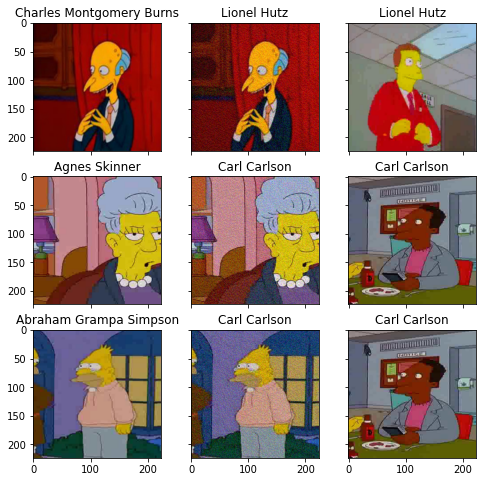

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8),
                       sharey=True, sharex=True)
for i in range(3):
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    adv_im = adv_images[random_characters]
    adv_pred = simple_cnn(adv_im.unsqueeze(dim=0).to(DEVICE))
    adv_label = torch.argmax(adv_pred, 1)
    adv_label = val_dataset.label_encoder.inverse_transform([adv_label.cpu()])[0]
    adv_label1 = " ".join(map(lambda x: x.capitalize(),
                                adv_label.split('_')))
    img_label = val_dataset.label_encoder.inverse_transform([label])[0]
    img_label = " ".join(map(lambda x: x.capitalize(),
                                img_label.split('_')))
    image_adv_category = SimpsonsDataset(
        [Path(f'dataset/train/simpsons_dataset/{adv_label}/pic_0000.jpg')], mode='val')[0][0]
    imshow(im_val.data.cpu(), title=img_label, plt_ax=ax[i][0])
    imshow(adv_im.data.cpu(), title=adv_label1, plt_ax=ax[i][1])
    imshow(image_adv_category, title=adv_label1, plt_ax=ax[i][2])

Таким образом, при обучении на определенном виде атак, можно получить нейросеть, которая будет более устойчивой к этим атакам, однако свойство устойчивости не сохраняется, если к ней применить новые атаки, о которых она не знала во время обучения. В случае целенаправленной атаке, для того, чтобы получить устойчивую нейросеть, необходимо ее обучить на атаке каждого класса. В случае наличия 1000 классов, это невыполнимая задача. Поэтому такой способ, как обучение на состязательных атаках не способен защитить нейросеть от состязательных атак в общем случае. В связи с этим необходимо изучать другие способы получения устойчивых нейросетей.

# Заключение


В данной работе удалось выполнить
1.   Рассмотрение и реализация двух методов состязательных атак.
2.   Проведение успешных экспериментов по аугментации данных и регуляризации сети путем обучения нейросети на FGSM атаках. При помощи такого подхода удалось повысить качество на экземплярах маленьких классов.
3. Проведение экспериментов по защиты нейронных сетей от состязательных атак путем обучения нейросетей на данных атаках. Удалось повысить устойчивость сетей при их проверке на атаках, на которых они обучались. Однако такой способ защиты не обладает переносимостью и от использования других типов атак не защищает.
К тому же есть статьи, которые говорят о том, что одни и те же примеры состязательных атак являются успешными в нейросетях с абсолютно разной архитектурой.

В связи с вышеуказанными утверждениями можно сделать вывод о том, что развитие способов защиты от целенаправленных атак является очень важным направлением в искусственном интеллекте. 

